### Predicting Recessions to Improve Asset Allocation Strategies
---
This program aims to predict the occurrence of economic recessions 12-months in the future by training a model on past macroeconomic data. These model scores are then used to develop simple trading rules that aim to shift a theoretical investor's portfolio out of the stock market before recessions - and presumably stock market declines - occur.

The independent variables being used to train the model are the yield curve, expressed as the difference between yields on 10-yr and 3-month US Treasury securities, the Civilian Unemployment Rate (U3), and the NFCI Nonfinancial Leverage subindex. These variables are aggregated by month, and then smoothed using a 3-month SMA. The dependent variable is a recession indicator, with one (1) representing the occurrence of recession, and zero (0) the absence of recession. This indicator is shifted 12-months into the past as stock market declines do not perfectly coincide with the onset of recessions, and the aim here is to give investors sufficient advanced warning to lower their equity allocation. All data used to build the recession prediction model is obtained from the Federal Reserve Bank of St. Louis Economic Database (FRED), while S&P500 return data is drawn from Professor Robert Shiller's publically available dataset. 

**Sources:**
1. 10YR - 3M Treasury spread. (T10Y3M column, Frequency = Daily):  https://fred.stlouisfed.org/series/T10Y3M 
2. Recession Indicator (USREC column in data): https://fred.stlouisfed.org/series/USREC 
3. Unemployment rate (UNRATE column, Frequency = Monthly):  https://fred.stlouisfed.org/series/UNRATE
4. NFCI Nonfinancial Leverage Subindex (Frequency = Weekly): https://fred.stlouisfed.org/series/NFCINONFINLEVERAGE
5. 10-yr constant maturity rate (DGS10): https://fred.stlouisfed.org/series/DGS10
6. S&P500 data: http://www.econ.yale.edu/~shiller/data.htm
7. Consumer Price Index (CPI): https://fred.stlouisfed.org/series/CPIAUCSL

In [68]:
from fredapi import Fred
import pandas as pd
pd.options.mode.chained_assignment = None

from collections import defaultdict
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import fbeta_score, roc_curve, roc_auc_score, accuracy_score, precision_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import confusion_matrix

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
import sklearn.exceptions as sklearn_except

%matplotlib inline

In [2]:
path = "Insert path to save plots at here"

### Bring in FRED Data with API
* Fred API instructions: https://github.com/mortada/fredapi
* Request an API key: https://research.stlouisfed.org/docs/api/api_key.html

In [4]:
fred = Fred(api_key="enter your api key here")

T10Y3M = pd.Series(fred.get_series("T10Y3M"), name="T10Y3M")
unrate = pd.Series(fred.get_series("UNRATE"), name = "UNRATE")
NFCI = pd.Series(fred.get_series("NFCINONFINLEVERAGE"), name="NFCI")
us_rec = pd.Series(fred.get_series("USREC"), name="USREC")
DGS10 = pd.Series(fred.get_series("DGS10"), name="DGS10")
CPI = pd.Series(fred.get_series("CPIAUCSL"), name="CPI")

### Visualize data

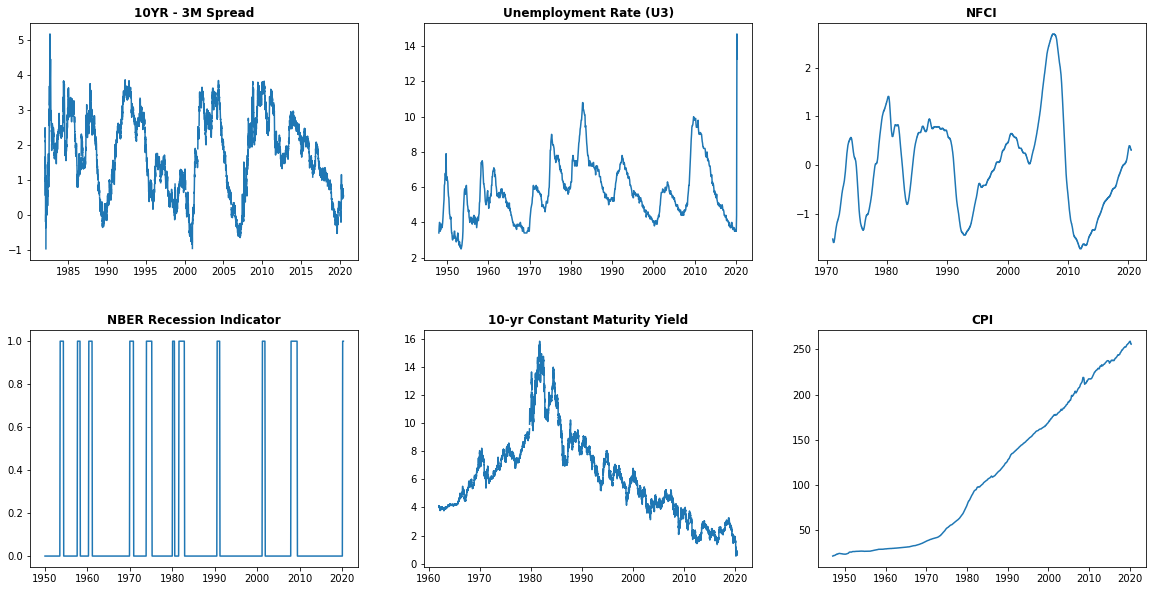

In [5]:
fig, axs = plt.subplots(2,3, figsize=(20,10), gridspec_kw = {"hspace":0.3})

axs[0][0].plot(T10Y3M)
axs[0][0].set_title("10YR - 3M Spread", weight="bold")

axs[0][1].plot(unrate)
axs[0][1].set_title("Unemployment Rate (U3)", weight="bold")

axs[0][2].plot(NFCI)
axs[0][2].set_title("NFCI", weight="bold")

# Recession data goes back to 1854, limit to more recent history
axs[1][0].plot(us_rec.loc[us_rec.index.year>=1950])
axs[1][0].set_title("NBER Recession Indicator", weight="bold")

axs[1][1].plot(DGS10)
axs[1][1].set_title("10-yr Constant Maturity Yield", weight="bold")

axs[1][2].plot(CPI)
axs[1][2].set_title("CPI", weight="bold");

In [6]:
df = pd.concat([T10Y3M, NFCI, unrate, us_rec, DGS10, CPI], axis=1)

In [7]:
df.head()

,T10Y3M,NFCI,UNRATE,USREC,DGS10,CPI
1854-12-01,NaN,NaN,NaN,1.0,NaN,NaN
1855-01-01,NaN,NaN,NaN,0.0,NaN,NaN
1855-02-01,NaN,NaN,NaN,0.0,NaN,NaN
1855-03-01,NaN,NaN,NaN,0.0,NaN,NaN
1855-04-01,NaN,NaN,NaN,0.0,NaN,NaN


### T10Y3M spread and 10-yr Treasury rates are daily, aggregate by month using the mean
* Also **dropna( )** to narrow down DataFrame to dates where all columns have values

In [8]:
year_month = pd.Series([str(x) for x in df.index.year.values]) + "-" + pd.Series([str(x) for x in df.index.month.values])
df["year_month"] = year_month.values

df = df.groupby("year_month")[["T10Y3M", "UNRATE", "NFCI", "USREC", "DGS10", "CPI"]].mean().dropna()

In [9]:
df.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI
year_month,,,,,,
1982-1,1.676000,8.6,0.6760,1.0,14.594000,94.4
1982-10,2.939000,10.4,-0.3540,1.0,10.906500,98.1
1982-11,2.204211,10.8,-0.4700,1.0,10.550526,98.0
1982-12,2.337273,10.8,-0.5700,0.0,10.540000,97.7
1982-2,0.146111,8.9,0.5625,1.0,14.425556,94.7


In [10]:
# Convert index to datetime and sort. Drop index name
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.index.name = None

In [11]:
# Make column containing change in CPI
df["CPI_chg"] = df["CPI"].pct_change()

In [12]:
df.tail()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI,CPI_chg
2020-01-01,0.205238,3.6,0.3600,0.0,1.757619,258.820,0.001455
2020-02-01,-0.040526,3.5,0.3975,0.0,1.504211,259.050,0.000889
2020-03-01,0.574545,4.4,0.3975,1.0,0.870000,257.953,-0.004235
2020-04-01,0.519524,14.7,0.3725,1.0,0.657619,255.902,-0.007951
2020-05-01,0.546500,13.3,0.3380,1.0,0.674000,255.768,-0.000524


### Pull in S&P500 data, downloaded from http://www.econ.yale.edu/~shiller/data.htm

In [13]:
SP500 = pd.read_csv(path + "/input_files/S&P500.csv",index_col=0, header=0, names=["S&P500","divs_annualized"])

In [14]:
# Join SP500 on df
df = df.join(SP500)

In [15]:
df.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI,CPI_chg,S&P500,divs_annualized
1982-01-01,1.676000,8.6,0.6760,1.0,14.594000,94.4,NaN,117.3,6.66
1982-02-01,0.146111,8.9,0.5625,1.0,14.425556,94.7,0.003178,114.5,6.69
1982-03-01,0.546522,9.0,0.4525,1.0,13.861304,94.7,0.000000,110.8,6.72
1982-04-01,0.527143,9.3,0.3300,1.0,13.871905,95.0,0.003168,116.3,6.75
1982-05-01,0.908500,9.4,0.2150,1.0,13.622500,95.9,0.009474,116.4,6.78


### Create column for S&P500 monthly returns.
Monthly S&P500 return = $$ \dfrac{SP500_0 + dividends_0}{SP500_{-1}} $$

**Where:**
* SP500<sub>-1</sub> = prior month's S&P500 level
* SP500<sub>0</sub> = current month's S&P500 level
* dividends<sub>0</sub> = dividends received in current period

In [16]:
# S&P500 fields
df["divs_monthly"] = df["divs_annualized"] / 12
df["S&P500_total_return"] = (df["S&P500"] + df["divs_monthly"]) / df["S&P500"].shift(1) - 1
df["real_S&P500_total_return"] = df["S&P500_total_return"] - df["CPI_chg"]

In [17]:
# Sanity check, calculate annual stock returns
term = (df.index.max() - df.index.min()).days/365
print("S&P500 CAGR:",round((np.prod(df["S&P500_total_return"]+1)**(1/term) - 1)*100,2),"%")

S&P500 CAGR: 11.46 %


### Create columns for 10-yr Treasury monthly returns.

 Monthly Note Return = $$\left(\dfrac{r_{-1} * \left(1-\dfrac{1}{(1+r_0)^{10}}\right)}{r_0}\right)+\left(\dfrac{1}{(1+r_0)^{10}}\right)-1 + \dfrac{r_{-1}}{12}$$ 

**Where:**
* r<sub>-1</sub> = prior month's T-Note yield
* r<sub>0</sub> = current month's T-Note yield

In [18]:
# First create column with prior month's yield
df["DGS10_prior"] = df["DGS10"].shift(1, fill_value=0)

In [19]:
# Calculate monthly return on 10-yr Notes
df["treasury_return"] = (df["DGS10_prior"]/100*(1 - 1/(1 + df["DGS10"]/100)**10))/(df["DGS10"]/100) +\
                                            1/(1 + df["DGS10"]/100)**10 - 1 + df["DGS10_prior"]/100/12

In [20]:
df.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI,CPI_chg,S&P500,divs_annualized,divs_monthly,S&P500_total_return,real_S&P500_total_return,DGS10_prior,treasury_return
1982-01-01,1.676000,8.6,0.6760,1.0,14.594000,94.4,NaN,117.3,6.66,0.5550,NaN,NaN,0.000000,-0.743917
1982-02-01,0.146111,8.9,0.5625,1.0,14.425556,94.7,0.003178,114.5,6.69,0.5575,-0.019118,-0.022296,14.594000,0.020804
1982-03-01,0.546522,9.0,0.4525,1.0,13.861304,94.7,0.000000,110.8,6.72,0.5600,-0.027424,-0.027424,14.425556,0.041613
1982-04-01,0.527143,9.3,0.3300,1.0,13.871905,95.0,0.003168,116.3,6.75,0.5625,0.054716,0.051548,13.861304,0.010995
1982-05-01,0.908500,9.4,0.2150,1.0,13.622500,95.9,0.009474,116.4,6.78,0.5650,0.005718,-0.003756,13.871905,0.024763


In [21]:
# Real note return
df["real_treasury_return"] = df["treasury_return"] - df["CPI_chg"]

df["treasury_return"].iloc[0]=0
df["real_treasury_return"].iloc[0]=0

In [22]:
# Sanity check, calculate annual Note returns
df["rel_treasury_return"] = 1 + df["treasury_return"]
print((df.groupby(df.index.year)["rel_treasury_return"].prod()-1))
print("")
print(f"10-YR Treasury CAGR {df.index.min().year}-{df.index.max().year}:", np.prod(df["treasury_return"]+1)**(1/term)-1)

1982    0.405863
1983    0.034912
1984    0.152502
1985    0.272652
1986    0.244697
1987   -0.043218
1988    0.083241
1989    0.183095
1990    0.070959
1991    0.156965
1992    0.096370
1993    0.139835
1994   -0.072950
1995    0.240103
1996    0.020020
1997    0.104531
1998    0.151801
1999   -0.066019
2000    0.146605
2001    0.063159
2002    0.137817
2003    0.019965
2004    0.045861
2005    0.023734
2006    0.040605
2007    0.086701
2008    0.193444
2009   -0.066807
2010    0.057753
2011    0.152046
2012    0.042170
2013   -0.079287
2014    0.090052
2015    0.017820
2016   -0.004527
2017    0.031490
2018   -0.008954
2019    0.112959
2020    0.122394
Name: rel_treasury_return, dtype: float64

10-YR Treasury CAGR 1982-2020: 0.08406077042811999


### Adjust features and target
* Shift USREC indicator back 12-months, since the aim is to forecast a recession one year ahead
* Create smoothed X variables, and separate df to account for the varied column lengths

In [23]:
# Shift USREC back 12 months 
df["USREC_shifted"] = df["USREC"].shift(-12, fill_value=0)

# Check shifted data
df[["USREC","USREC_shifted"]].iloc[-150:-135]

,USREC,USREC_shifted
2007-12-01,0.0,1.0
2008-01-01,1.0,1.0
2008-02-01,1.0,1.0
2008-03-01,1.0,1.0
2008-04-01,1.0,1.0
2008-05-01,1.0,1.0
2008-06-01,1.0,1.0
2008-07-01,1.0,0.0
2008-08-01,1.0,0.0
2008-09-01,1.0,0.0


In [24]:
# Create copy of df
df_SMA = df.copy()

In [25]:
# 3-month moving averages to smooth out noise
df_SMA["T10Y3M_SMA"] = df_SMA["T10Y3M"].rolling(3).mean() 
df_SMA["UNRATE_SMA"] = df_SMA["UNRATE"].rolling(3).mean()
df_SMA["NFCI_SMA"] = df_SMA["NFCI"].rolling(3).mean()

# Drop nan in df_SMA
df_SMA.dropna(inplace=True)

In [26]:
df_SMA.head()

,T10Y3M,UNRATE,NFCI,USREC,DGS10,CPI,CPI_chg,S&P500,divs_annualized,divs_monthly,S&P500_total_return,real_S&P500_total_return,DGS10_prior,treasury_return,real_treasury_return,rel_treasury_return,USREC_shifted,T10Y3M_SMA,UNRATE_SMA,NFCI_SMA
1982-03-01,0.546522,9.0,0.4525,1.0,13.861304,94.7,0.000000,110.8,6.72,0.560000,-0.027424,-0.027424,14.425556,0.041613,0.041613,1.041613,0.0,0.789544,8.833333,0.563667
1982-04-01,0.527143,9.3,0.3300,1.0,13.871905,95.0,0.003168,116.3,6.75,0.562500,0.054716,0.051548,13.861304,0.010995,0.007827,1.010995,0.0,0.406592,9.066667,0.448333
1982-05-01,0.908500,9.4,0.2150,1.0,13.622500,95.9,0.009474,116.4,6.78,0.565000,0.005718,-0.003756,13.871905,0.024763,0.015289,1.024763,0.0,0.660722,9.233333,0.332500
1982-06-01,1.220909,9.6,0.1150,1.0,14.299545,97.0,0.011470,109.7,6.81,0.567500,-0.052685,-0.064155,13.622500,-0.023554,-0.035025,0.976446,0.0,0.885517,9.433333,0.220000
1982-07-01,2.082857,9.8,0.0020,1.0,13.946190,97.5,0.005155,109.4,6.82,0.568333,0.002446,-0.002709,14.299545,0.030386,0.025232,1.030386,0.0,1.404089,9.600000,0.110667


### Visualize features and their relationship with the target, and begin modeling 
* First start with **Logistic Regression**
    * Project seems well-suited to it: data is relatively linearly separable and I would prefer to maintain interpretability

In [27]:
# First, enter date at which to split train and test data. Ideally set to a year end (month = 12)
train_split = "2002-12-01"
train_split = datetime(int(train_split[0:4]), int(train_split[5:7]), int(train_split[9:11]))

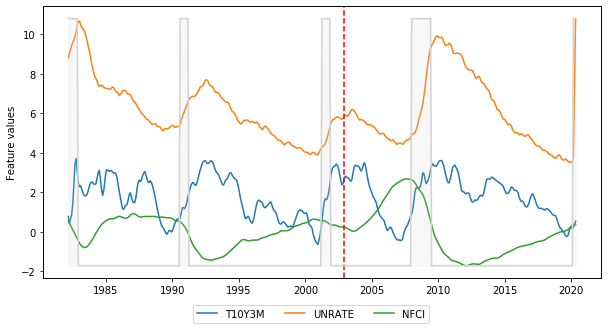

In [28]:
# Look at features and target together -- red line represents train / test split
plt.figure(figsize=(10,5))
plt.plot(df_SMA.index, df_SMA["T10Y3M_SMA"], label="T10Y3M")
plt.plot(df_SMA["UNRATE_SMA"], label="UNRATE")
plt.plot(df_SMA["NFCI_SMA"], label="NFCI")
plt.legend(ncol=3, bbox_to_anchor=(0.70,-0.08), prop={"size": 10})
plt.ylabel("Feature values")
plt.axvline(train_split,color="r", linestyle="--")

ax1 = plt.twinx()
ax1.plot(df_SMA["USREC"], "lightgray", label="USREC")
ax1.fill_between(df_SMA.index,df_SMA["USREC"],color="lightgray",alpha=0.15)
ax1.get_yaxis().set_visible(False)

plt.savefig(path+"/output_files/final/train_test_split.png", dpi=300);

In [29]:
# Separate features by shifted recession status
T10Y3M_0 = df_SMA[df_SMA["USREC_shifted"]==0]["T10Y3M_SMA"]
T10Y3M_1 = df_SMA[df_SMA["USREC_shifted"]==1]["T10Y3M_SMA"]

UNRATE_0 = df_SMA[df_SMA["USREC_shifted"]==0]["UNRATE_SMA"]
UNRATE_1 = df_SMA[df_SMA["USREC_shifted"]==1]["UNRATE_SMA"]

NFCI_0 = df_SMA[df_SMA["USREC_shifted"]==0]["NFCI_SMA"]
NFCI_1 = df_SMA[df_SMA["USREC_shifted"]==1]["NFCI_SMA"]

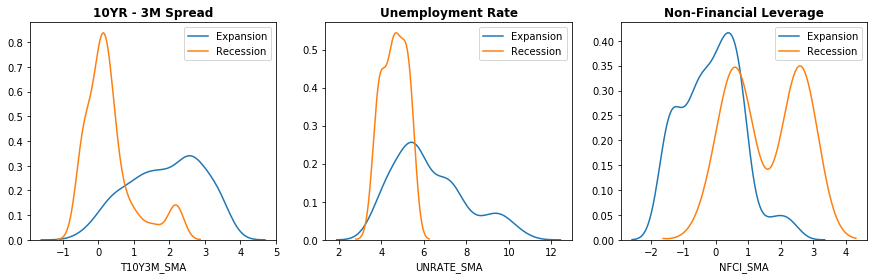

In [30]:
# View feature linear separability 
fig, axs = plt.subplots(1,3, figsize=(15,4))
sns.distplot(T10Y3M_0, hist=False, ax=axs[0], label="Expansion")
sns.distplot(T10Y3M_1, hist=False, ax=axs[0], label="Recession")
axs[0].set_title("10YR - 3M Spread", weight="bold")
axs[0].legend()

sns.distplot(UNRATE_0, hist=False, ax=axs[1], label="Expansion")
sns.distplot(UNRATE_1, hist=False, ax=axs[1], label="Recession")
axs[1].set_title("Unemployment Rate", weight="bold")

sns.distplot(NFCI_0, hist=False, ax=axs[2], label="Expansion")
sns.distplot(NFCI_1, hist=False, ax=axs[2], label="Recession")
axs[2].set_title("Non-Financial Leverage", weight="bold")

plt.savefig(path + "/output_files/final/distplot.png", dpi=300);

In [31]:
# Examine class weights in the data
print("Recessions account for:", "{:.1f}".format(df["USREC"].value_counts()[1]/df["USREC"].value_counts()[0]*100),
      "% of observations")

Recessions account for: 11.6 % of observations


### Determine ratio of monthly returns for the S&P500 in recessions to S&P500 in expansions

In [32]:
avg_exp_ret = df[df["USREC"] == 0]["S&P500_total_return"].mean()
avg_rec_ret = df[df["USREC"] == 1]["S&P500_total_return"].mean()

print(f"The S&P500 has mean monthly returns of {avg_exp_ret*100:.3f}% in expansions and mean \
monthly returns of {avg_rec_ret*100:.3f}% in recessions.")
beta = -avg_rec_ret / avg_exp_ret
print(f"Beta: {beta:.3f}")

The S&P500 has mean monthly returns of 1.133% in expansions and mean monthly returns of -0.411% in recessions.
Beta: 0.363


### The S&P500's mean recession month is *less* unprofitable than the mean expansion month is profitable
Assuming this pattern holds in the future, for portfolio management purposes an ideal model would place more importance on precision (being confident a month classified as a recession is truly a recession), than recall (accurately classifying all recessions as such).

### Logistic Regression
* Set training data up to the end of the 2001 recession (November 2001)
* Set test data to all dates after and including December 2001

In [33]:
X = df_SMA[["T10Y3M_SMA","UNRATE_SMA","NFCI_SMA"]]
y = df_SMA["USREC_shifted"]

In [34]:
# Set train and test sets
X_train = X[X.index <= train_split]
y_train = y[y.index <= train_split]
X_test = X[X.index > train_split]
y_test = y[y.index > train_split]

# Scale X_train and X_test
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train)
X_test_lr = scaler.transform(X_test)

In [35]:
# Perform multiple validations to determine optimal class_weight in Logistic Regression
warnings.filterwarnings("ignore", category=sklearn_except.UndefinedMetricWarning)

# Create list of class weights
class_weights = [{0:weight, 1:1-weight} for weight in np.arange(0.05,1,0.05)]

# During validation, training the model requires positive classes, so set first slice to include some [1's]
first_rec = y_train[y_train.index=="1989-12-01"].index[0]
num_years = int((train_split-first_rec).days/365)

train_dates = [first_rec]+[first_rec + relativedelta(months=+12) * i for i in range(1,num_years)]

fbeta_dict = defaultdict(list)
for date in train_dates:
        X_train_cv = X_train[X_train.index <= date]
        y_train_cv = y_train[y_train.index <= date]
        X_test_cv = X_train[date+relativedelta(months=+1) : date + relativedelta(months=+12)]
        y_test_cv = y_train[date+relativedelta(months=+1) : date + relativedelta(months=+12)]
        
        for weight in class_weights:
            logistic_regression = LogisticRegression(random_state=4, class_weight=weight)
            logistic_regression.fit(X_train_cv, y_train_cv)
            preds = logistic_regression.predict(X_test_cv)
            fbeta = round(fbeta_score(y_test_cv,preds,beta=beta),4)
            
            if fbeta==0:
                pass
            else:
                fbeta_dict[str(weight)].append(fbeta)

In [36]:
# loop through dict to get weights that yield max average fbeta
max_fbeta = 0
for key, values in fbeta_dict.items():
    fbeta = np.mean(values)
    if fbeta > max_fbeta:
        max_fbeta = fbeta
        max_weights = key
max_weights = ast.literal_eval(max_weights)
print("max_weights:",max_weights)
print("Mean max fbeta:",max_fbeta)

max_weights: {0: 0.2, 1: 0.8}
Mean max fbeta: 0.8739


In [37]:
# Instantiate model and fit with optimal class_weight found in validation
logistic_regression = LogisticRegression(random_state=4, class_weight=max_weights)
logistic_regression.fit(X_train_lr, y_train);

test_scores_lr = logistic_regression.predict_proba(X_test_lr)[:,1]
test_pred_lr = logistic_regression.predict(X_test_lr)

In [38]:
# Print coefficients
list(zip(X.columns,logistic_regression.coef_[0]))

[('T10Y3M_SMA', -1.8661222573185285),
 ('UNRATE_SMA', -0.5647435399134783),
 ('NFCI_SMA', 1.299403396277321)]

### Function to create heat map for confusion matrix

In [39]:
def create_confusion_matrix(y_test, test_pred, test_scores, title, filename):
    c_matrix = confusion_matrix(y_test, test_pred)
    plt.figure(dpi=80)
    sns.heatmap(c_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
    xticklabels=['Expansion', 'Recession'],
    yticklabels=['Expansion', 'Recession'])
    plt.title(title,weight="bold")
    plt.xlabel('prediction',weight="bold",labelpad=10)
    plt.ylabel('actual',weight="bold",labelpad=10)
    
    print(f"ROC AUC: {roc_auc_score(y_test, test_scores):.3f}")
    print(f"F_{beta:.3f} Score: {fbeta_score(y_test, test_pred, beta):.3f}")
    print(f"Precision: {precision_score(y_test, test_pred):.3f}")
    print(f"Recall: {recall_score(y_test, test_pred):.3f}")
    print(f"Accuracy: {accuracy_score(y_test, test_pred):.3f}")
    plt.savefig(path + "/output_files/final/Model plots/" + filename + ".png", dpi=300)

ROC AUC: 0.945
F_0.363 Score: 0.420
Precision: 0.395
Recall: 0.810
Accuracy: 0.856


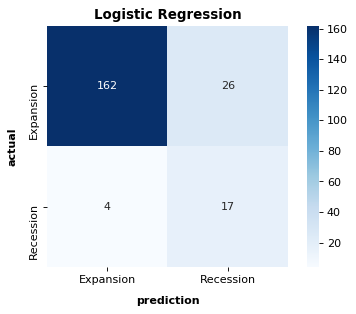

In [40]:
create_confusion_matrix(y_test, test_pred_lr, test_scores_lr, "Logistic Regression", "LR Confusion Matrix")

### ROC Curve plotting function

In [41]:
def plot_ROC_curves(y_test, test_scores, title, filename):
    fpr, tpr, _ = roc_curve(y_test, test_scores)
    plt.plot(fpr, tpr, label=f"{title}")

    x = np.linspace(0,1,1000)
    plt.plot(x, x, linestyle='--')

    plt.title(f"{title} ROC Curve", weight="bold")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    plt.savefig(path + "/output_files/final/Model plots/" + filename + ".png", dpi=300)

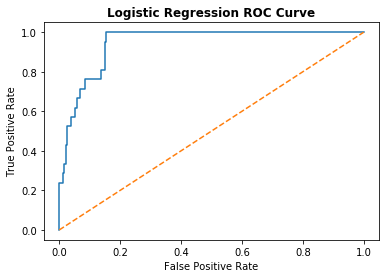

In [42]:
plot_ROC_curves(y_test, test_scores_lr, "Logistic Regression", "Logistic_Regression_ROC_AUC")

### Function to plot results features and model score

In [43]:
def plot_results(df, column_name, file_name, title):
    fig, axs = plt.subplots(2,figsize=(10,12))
    for col in X.columns:
        if "SMA" in col:
            label = label=col[:-4]
        else:
            label = col
        axs[0].plot(df[col], "--", label=label)
        
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    axs[0].set_ylabel("Feature values")
    axs[0].set_title(title, weight="bold")
    axs[0].axvline(train_split,color="r")
    
    ax1 = axs[0].twinx()
    ax1.plot(df["USREC"], "lightgray")
    ax1.fill_between(df.index,df["USREC"],color="lightgray",alpha=0.25)
    ax1.plot(df[column_name], "maroon", label="REC_SCORE")
    ax1.set_ylabel("Recession Score", labelpad=5)

    fig.legend(ncol=4, bbox_to_anchor=(0.82,-0.1), bbox_transform=ax1.transAxes, prop={"size": 10})
    plt.subplots_adjust(hspace=.3)
    
    # Plot S&P500
    axs[1].plot(df.index, (1+df["S&P500_total_return"]).rolling(12).apply(np.prod, raw=True)-1, label="S&P500")
    axs[1].set_ylabel("S&P500 rolling 12-month return")
    axs[1].set_title("Recessions (shaded) with S&P500 Overlay", weight="bold")
 
    ax2 = axs[1].twinx()
    ax2.plot(df["USREC"], "lightgray", label="USREC")
    ax2.fill_between(df.index,df["USREC"],color="lightgray",alpha=.25)
    ax2.axes.get_yaxis().set_ticks([])
    axs[1].axhline(y=0, color="r", linestyle="-")
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
    plt.savefig(path + "/output_files/final/Model plots/" + file_name + ".png", dpi=300)

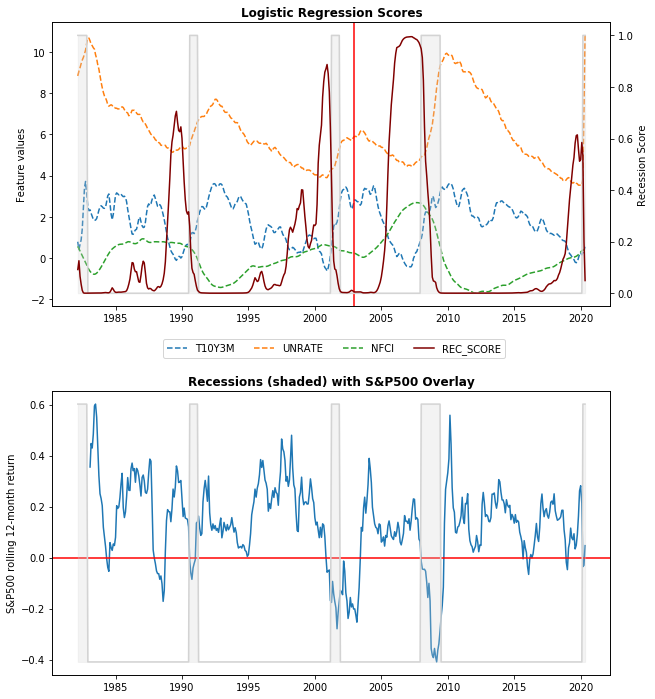

In [50]:
# Run model on full dataset to generate prediction scores
df_SMA["LogReg_rec_score"] = logistic_regression.predict_proba(scaler.transform(X))[:,1]
plot_results(df_SMA, "LogReg_rec_score", "Logistic_Regression_Output", "Logistic Regression Scores")

In [740]:
with open(path+"/pickles/Logistic_Regression_Model.pkl","wb") as picklefile:
    pickle.dump(logistic_regression, picklefile)

### Random Forest Classifier - parameter tuning
* Iterate over various **max_depths** and **class_weights** to maximize F_Beta score

In [44]:
# Perform multiple validations to determine  Random Forest Classifier hyperparameters that yield max average fbeta
max_depths = range(1,21)
fbeta_dict_rf = defaultdict(list)

for date in train_dates:
    X_train_cv = X_train[X_train.index <= date]
    y_train_cv = y_train[y_train.index <= date]
    X_test_cv = X_train[date+relativedelta(months=+1) : date + relativedelta(months=+12)]
    y_test_cv = y_train[date+relativedelta(months=+1) : date + relativedelta(months=+12)]
    for depth in max_depths:
        for weight in class_weights:
            random_forest = RandomForestClassifier(random_state=4, class_weight=weight, max_depth=depth)
            random_forest.fit(X_train_cv, y_train_cv)
            preds = random_forest.predict(X_test_cv)
            fbeta = round(fbeta_score(y_test_cv,preds,beta=beta),4)
            
            if fbeta == 0:
                pass
            else:
                fbeta_dict_rf["class_weight:"+str(weight)+", max_depth:"+str(depth)].append(fbeta)

In [46]:
# loop through dict to get hyperparameters 
max_fbeta_rf = 0
for key, values in fbeta_dict_rf.items():
    fbeta_rf = np.mean(values)
    if fbeta_rf > max_fbeta_rf:
        max_fbeta_rf = fbeta_rf
        max_key = key
        
#max_weights_rf = ast.literal_eval(max_weights)
print("Optimal parameters:",max_key)
print("Optimal Random Forest FBeta:",max_fbeta_rf)

Optimal parameters: class_weight:{0: 0.3, 1: 0.7}, max_depth:2
Optimal Random Forest FBeta: 0.85355


### FBeta during validations indicate Logistic Regression is optimal model -- use LR going forward

### Develop trading rules to outperform passive portfolios
Find parameter values that maximize portfolio returns under various simulations. Parameters to adjust in each simulation:
1. **Risk off model score** - Model score at which to shift out of equities into bonds
2. **Risk on model score** - Model score at which to shift back into equities
3. **Portfolio weights** - The degree to which the portfolio shifts the **equity | bond** allocation

In [47]:
# Enter asset allocation being tested (stocks and bond weights) and create lists of variables to iterate over
stock_weight = 0.6
bond_weight = round(1-stock_weight,1)
asset_mix = str(int(stock_weight*100)) + ":" + str(int(bond_weight*100)) + "_return"
portfolio_weights = [{"stocks":x, "bonds":1-x} for x in np.arange(0.1,stock_weight + 0.1,0.1)]

risk_off_scores = np.arange(0.05,1.0,0.05)
risk_on_scores = np.arange(0.05,1.0,0.05)

In [48]:
# Create fields to represent returns of various stock|bond allocations
# Also, since bond returns were abnormally high in the 1980s-1990s, create field with TTM Treasury return
df_SMA["ttm_treasury_return"] = (1+(df_SMA["DGS10"].iloc[-12:].mean()/100))**(1/12)-1
df_SMA["60:40_return"] = 0.6 * df_SMA["S&P500_total_return"] + 0.4 * df_SMA["treasury_return"]
df_SMA["80:20_return"] = 0.8 * df_SMA["S&P500_total_return"] + 0.2 * df_SMA["treasury_return"]
df_SMA["100:0_return"] = df_SMA["S&P500_total_return"]

df_SMA["60:40_ttm_return"] = 0.6 * df_SMA["S&P500_total_return"] + 0.4 * df_SMA["ttm_treasury_return"]
df_SMA["80:20_ttm_return"] = 0.8 * df_SMA["S&P500_total_return"] + 0.2 * df_SMA["ttm_treasury_return"]

In [51]:
allocation_fields = ["LogReg_rec_score","USREC","S&P500_total_return","treasury_return","ttm_treasury_return",
                     "60:40_return","60:40_ttm_return","80:20_return","80:20_ttm_return","100:0_return"]

allocation_train = df_SMA[df_SMA.index <= train_split][allocation_fields]
allocation_test = df_SMA[df_SMA.index > train_split][allocation_fields]

### Set default stock and bond weights for the portfolio
This is the allocation held during months where the model does not signal to adjust portfolio weights.

In [52]:
allocation_train["stock_weight"] = stock_weight
allocation_train["bond_weight"] = bond_weight

### Run through various simulations to find optimal portfolio trading rules

In [53]:
max_return = 0

# Iterate through model score thresholds that will determine when to shift out of equities into bonds. 
for risk_off_score in risk_off_scores:
    # Create list of dates where model score is >= risk_off_score being tested in current loop and is greater
    # than the model's score 12-months ago (to ensure model score is rising).
    risk_off_dates = allocation_train[(allocation_train["LogReg_rec_score"] >= risk_off_score) &
                   (allocation_train["LogReg_rec_score"] > allocation_train["LogReg_rec_score"].shift(12,fill_value=0))].index

    # Calculate days between each successive date and create zip object combining dates and those days between 
    days_between = [risk_off_dates[i+1] - risk_off_dates[i] for i in range(len(risk_off_dates)-1)]
    dates_zipped = list(zip(days_between,risk_off_dates[1:]))
    
    # Create list of the first days in each cycle where the risk_off_score is hit. Add one month to account for 
    # the lag between when a user would see the score and when they could adjust their portfolio.
    # Delineate between different cycles by limiting dates to those over one year apart from the prior date.
    try:
        risk_off_starts = [risk_off_dates[0]+relativedelta(months=+1)] + [element[1]+relativedelta(months=+1) 
                                                                      for element in dates_zipped 
                                                                      if element[0].days > 365]
    except:
        continue
    
    # Iterate through risk_on_scores to test scores and corresponding dates at which to get back into stocks
    for risk_on_score in risk_on_scores:
        try:
            risk_on_starts = [allocation_train[(allocation_train["LogReg_rec_score"]<=risk_on_score) & 
                                               (allocation_train["LogReg_rec_score"]<allocation_train["LogReg_rec_score"].shift(12,fill_value=0)) &
                                               (allocation_train.index > start)].index[0]+relativedelta(months=+1) 
                              for start in risk_off_starts]
        except:
            continue
        
        allocation_shift_cycles = list(zip(risk_off_starts,risk_on_starts))

        for weight in portfolio_weights:
            # Set trading_rule_returns field a default base allocation
            allocation_train["trading_rule_returns"] = allocation_train[asset_mix]

            # Change weights as simulations run and calculate trading_rule_returns with updated weights
            for cycle in allocation_shift_cycles:
                allocation_train["stock_weight"].loc[cycle[0]:cycle[1]] = weight["stocks"]
                allocation_train["bond_weight"].loc[cycle[0]:cycle[1]] = weight["bonds"]
                allocation_train["trading_rule_returns"].loc[cycle[0]:cycle[1]] =\
                allocation_train["stock_weight"] * allocation_train["S&P500_total_return"] +\
                allocation_train["bond_weight"] * allocation_train["treasury_return"]

            # If current loop's trading strategy > prior max_return, update optimal fields
            trading_return = np.prod(1 + allocation_train["trading_rule_returns"])
            if trading_return > max_return:
                max_return = trading_return
                allocation_train["optimal_stock_weight"] = allocation_train["stock_weight"]
                allocation_train["optimal_bond_weight"] = allocation_train["bond_weight"]
                allocation_train["optimal_returns"] = allocation_train["trading_rule_returns"]
                rule_params = {"risk off score": risk_off_score,"risk on score": risk_on_score,"weights": weight}
            
print(f"Max cumulative return: {max_return:0.3f}")
print(f"Rule parameters: {rule_params}")

Max cumulative return: 15.984
Rule parameters: {'risk off score': 0.7000000000000001, 'risk on score': 0.1, 'weights': {'stocks': 0.1, 'bonds': 0.9}}


In [54]:
allocation_train.tail()

,LogReg_rec_score,USREC,S&P500_total_return,treasury_return,ttm_treasury_return,60:40_return,60:40_ttm_return,80:20_return,80:20_ttm_return,100:0_return,stock_weight,bond_weight,trading_rule_returns,optimal_stock_weight,optimal_bond_weight,optimal_returns
2002-08-01,0.004534,0.0,0.011381,0.035582,0.001262,0.021061,0.007333,0.016221,0.009357,0.011381,0.6,0.4,0.021061,0.6,0.4,0.021061
2002-09-01,0.007889,0.0,-0.047585,0.035163,0.001262,-0.014485,-0.028046,-0.031035,-0.037815,-0.047585,0.6,0.4,-0.014485,0.6,0.4,-0.014485
2002-10-01,0.011179,0.0,-0.013662,-0.002543,0.001262,-0.009214,-0.007692,-0.011438,-0.010677,-0.013662,0.6,0.4,-0.009214,0.6,0.4,-0.009214
2002-11-01,0.009794,0.0,0.066265,-0.005415,0.001262,0.037593,0.040264,0.051929,0.053264,0.066265,0.6,0.4,0.037593,0.6,0.4,0.037593
2002-12-01,0.006590,0.0,-0.010342,0.004673,0.001262,-0.004336,-0.005700,-0.007339,-0.008021,-0.010342,0.6,0.4,-0.004336,0.6,0.4,-0.004336


In [55]:
# Print CAGRs under various scenarious
def show_returns(df):
    years = (df.index.max() - df.index.min()).days/365
    print(f"CAGR for constant {asset_mix[0:5]} portfolio:",round((np.prod(1 + df[asset_mix])**(1/years)-1)*100,2),"%")
    print("CAGR for 100% stocks portfolio:",round((np.prod(1 + df["S&P500_total_return"])**(1/years)-1)*100,2),"%")
    print("CAGR for trading rule portfolio:",round((np.prod(1 + df["optimal_returns"])**(1/years)-1)*100,2),"%")
    print("")
    print(f"Std Dev for constant {asset_mix[0:5]} portfolio: {np.std(df[asset_mix])*100:0.3f}%")
    print(f"Std Dev for trading rule portfolio: {np.std(df['optimal_returns'])*100:0.3f}%")

In [56]:
show_returns(allocation_train)

CAGR for constant 60:40 portfolio: 13.0 %
CAGR for 100% stocks portfolio: 13.64 %
CAGR for trading rule portfolio: 14.28 %

Std Dev for constant 60:40 portfolio: 2.423%
Std Dev for trading rule portfolio: 2.325%


In [57]:
# Test optimal return columns to ensure it is calculated properly
print("Optimal Returns Product:     ",round(np.prod(1+allocation_train["optimal_returns"]),8)) 
print("Optimal Returns Calculated:  ",round(np.prod(1+(allocation_train["S&P500_total_return"]*allocation_train["optimal_stock_weight"]+\
                                                             allocation_train["treasury_return"] *\
                                                             allocation_train["optimal_bond_weight"])),8))

Optimal Returns Product:      15.98436848
Optimal Returns Calculated:   15.98436848


### Function to view portfolio weights

In [58]:
def plot_weights(df, train_test):
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(df["optimal_stock_weight"],"--",label="Stock weight")
    ax.plot(df["optimal_bond_weight"],"--",label="Bond weight")
    ax.plot(df["LogReg_rec_score"],label="Model Score")
    ax.legend(loc="best")
    ax.set_ylabel("Portfolio weights & Model score")
    ax.set_yticks(np.arange(0, 1, 0.1))
    plt.subplots_adjust(hspace=0.4)
    
    ax1 = ax.twinx()
    ax1.plot(df["USREC"],"lightgray",label="USREC")
    ax1.fill_between(df.index,df["USREC"],color="lightgray",alpha=0.25)
    ax1.get_yaxis().set_visible(False)
    ax.legend(ncol=3, bbox_to_anchor=(0.8,-0.08), bbox_transform=ax1.transAxes, prop={"size": 10})
    
    plt.savefig(path+"/output_files/final/Portfolio plots/portfolio_weights_"+asset_mix+"_"+train_test+".png", dpi=300);

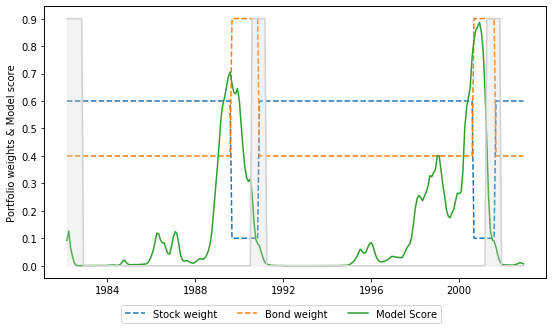

In [59]:
plot_weights(allocation_train, "train")

### Function to view portfolio returns

In [60]:
def plot_returns(df, train_test, title):
    start_amt = 10000
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(df.index,np.cumprod(1 + df["optimal_returns"])*start_amt, label="Trading Rule")
    ax.plot(np.cumprod(1 + df[asset_mix])*start_amt, label=asset_mix[0:5])
    ax.plot(np.cumprod(1 + df["treasury_return"])*start_amt, label="All Bonds")
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    ax.legend(ncol=3, bbox_to_anchor=(0.78,-0.08), prop={"size": 10})
    ax.set_ylabel("Growth of $10,000")
    
    ax1 = ax.twinx()
    ax1.plot(df["USREC"], "lightgray", label="USREC")
    ax1.fill_between(df.index,df["USREC"],color="lightgray",alpha=0.25)
    ax1.get_yaxis().set_visible(False)
    
    plt.savefig(path + "/output_files/final/Portfolio plots/" + asset_mix[0:5] + "_" + train_test + ".png", dpi=300);

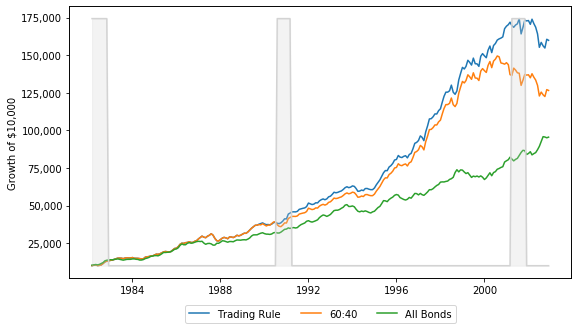

In [61]:
plot_returns(allocation_train, "train", "")

### Test the allocation rules on "unseen" data (2003 - May 2020)

In [62]:
portfolio_weights = rule_params["weights"]
risk_off_score = rule_params["risk off score"]
risk_on_score = rule_params["risk on score"]

allocation_test["optimal_returns"] = allocation_test[asset_mix]
allocation_test["optimal_stock_weight"] = stock_weight
allocation_test["optimal_bond_weight"] = bond_weight

# Create list of dates where model score is greater than risk_off_score being tested
test_risk_off_dates = allocation_test[(allocation_test["LogReg_rec_score"] >= risk_off_score) &
                   (allocation_test["LogReg_rec_score"] > allocation_test["LogReg_rec_score"]
                    .shift(12,fill_value=0))].index

# If no dates are marked as risk off dates, exit code
if test_risk_off_dates.empty:
    pass
else:
    # Calculate days between each successive date and create zip object combining dates and those days between 
    test_days_between = [test_risk_off_dates[i+1]-test_risk_off_dates[i] for i in range(len(test_risk_off_dates)-1)]
    test_dates_zipped = list(zip(test_days_between,test_risk_off_dates[1:]))

    # Create list of the first days where the risk_off_score is hit. Separate different periods by one year
    test_risk_off_starts = [test_risk_off_dates[0]+relativedelta(months=+1)]+[element[1]+relativedelta(months=+1) 
                                                                                    for element in test_dates_zipped if element[0].days > 365]

    # Iterate through the risk_off_start dates and find a corresponding end date at which to get back into stocks
    test_risk_on_starts = [allocation_test[(allocation_test["LogReg_rec_score"] <= risk_on_score) 
                                      & (allocation_test["LogReg_rec_score"] < allocation_test["LogReg_rec_score"]
                                         .shift(12,fill_value=0)) 
                                      & (allocation_test.index > start)].index[0]+relativedelta(months=+1) for start in test_risk_off_starts]

    test_allocation_shift_cycles = list(zip(test_risk_off_starts, test_risk_on_starts))

    for cycle in test_allocation_shift_cycles:
        allocation_test["optimal_stock_weight"].loc[cycle[0]:cycle[1]] = portfolio_weights["stocks"]
        allocation_test["optimal_bond_weight"].loc[cycle[0]:cycle[1]] = portfolio_weights["bonds"]
        allocation_test["optimal_returns"].loc[cycle[0]:cycle[1]] =\
        allocation_test["optimal_stock_weight"] * allocation_test["S&P500_total_return"] +\
        allocation_test["optimal_bond_weight"] * allocation_test["treasury_return"]

In [63]:
allocation_test.head()

,LogReg_rec_score,USREC,S&P500_total_return,treasury_return,ttm_treasury_return,60:40_return,60:40_ttm_return,80:20_return,80:20_ttm_return,100:0_return,optimal_returns,optimal_stock_weight,optimal_bond_weight
2003-01-01,0.004683,0.0,-0.002221,0.002050,0.001262,-0.000512,-0.000827,-0.001366,-0.001524,-0.002221,-0.000512,0.6,0.4
2003-02-01,0.004670,0.0,-0.064144,0.015268,0.001262,-0.032379,-0.037981,-0.048261,-0.051063,-0.064144,-0.032379,0.6,0.4
2003-03-01,0.004915,0.0,0.013084,0.011072,0.001262,0.012279,0.008355,0.012682,0.010720,0.013084,0.012279,0.6,0.4
2003-04-01,0.004654,0.0,0.052857,-0.009135,0.001262,0.028060,0.032219,0.040458,0.042538,0.052857,0.028060,0.6,0.4
2003-05-01,0.004891,0.0,0.053121,0.035582,0.001262,0.046105,0.032377,0.049613,0.042749,0.053121,0.046105,0.6,0.4


In [64]:
show_returns(allocation_test)

CAGR for constant 60:40 portfolio: 7.77 %
CAGR for 100% stocks portfolio: 9.2 %
CAGR for trading rule portfolio: 9.44 %

Std Dev for constant 60:40 portfolio: 2.079%
Std Dev for trading rule portfolio: 1.865%


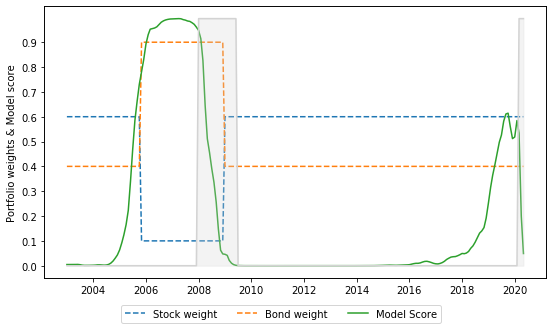

In [65]:
plot_weights(allocation_test, "test")

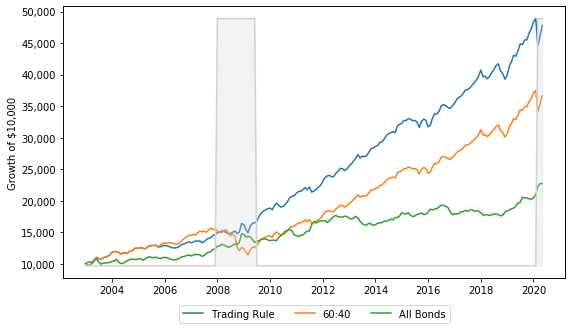

In [66]:
plot_returns(allocation_test, "test", "")

In [67]:
print("Ending investment of trading rule portfolio:",int(np.prod(1+allocation_test["optimal_returns"])*10000))
print("Ending investment of passive portfolio:",int(np.prod(1+allocation_test[asset_mix])*10000))
print("Ending investment of 100% bond portfolio:",int(np.prod(1+allocation_test["treasury_return"])*10000))

Ending investment of trading rule portfolio: 47779
Ending investment of passive portfolio: 36634
Ending investment of 100% bond portfolio: 22681
